# 2a Pràctica IA: Machine Learning


En aquesta pràctica el nostre objectiu és aplicar diferents classificadors a un problema real. En el nostre cas, prediurem les probabilitats de sobreviure al Titanic segons unes característiques elegides.

## 1 Observació de les Dades Porporcionades


### 1.1 Imports Necessaris

In [1]:
from sklearn.model_selection import train_test_split,GridSearchCV,learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,log_loss,f1_score,classification_report
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

### 1.1 Importació i Descripció del Dataset

Primer de tot, ens encarrem de carregar el dataset amb la llibreria pandas.

In [2]:
data=pd.read_csv("./dades.csv")

Durant aquesta fase de la EDA, hem de obtenir la màxima informació del dataset possible, mitjançant gràfics i altres mesures. L'objectiu d'aquesta observació de dades és entendre com ens han proporcionat la informació dels passatgers en el dataset per tal de després poder fer una netetja de les dades eficient i de qualitat. Anem a observar les primeres instàncies del dataset:

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


A primera vista, observam que el dataset conté la següent llista de columnes/atributs dels passatgers:
1. **PassengerId**: nombre identificador de cada passatger.
2. **Survived**: atribut que ens indica si el passatger va sobreviure (1) o va morir (0).
3. **Pclass**: columna que califica als passatgers segons la classe a la que pertanyien. En aquesta columna, els valors poden ser 1 (primera classe), 2 (segona classe), 3 (tercera classe). Bàsicament la diferencia entre classes és el preu dels billets.
4. **Name**: indica el nom del passatger.
5. **Sex**: atribut que indica si el passatger és un home (male) o dona (female). Per tant aquest només podrà prendre 2 valors.
6. **Age**: columna que indica l'edat del passatger.
7. **SibSp**: atribut booleà el qual ens indica si el passatger tenia germans (siblings) o dona (spouses) a bord.
8. **Parch**: atribut booleà que ens indica si el passatger tenia pares (parents) o fills (children) a bord.
9. **Ticket**: columna que ens mostra el que pareix algun tipus d'identificador del billet de cada passatger.
10. **Fare**: preu que va pagar cada passatger per la compra del billet del vaixell.
11. **Cabin**: identificador de la cabina (en cas que en tingués) del passatger.
12. **Embarked**: aquesta columna indica per quin port va embarcar al vaixell el passatger (C = Cherbourg, Q = Queenstown, S = Southampton).

Per tant, el data set conté 891 mostres amb 11 característiques, descartant la de survived. Una vegada identificat que signifiquen cada una de les columnes podem començar a treure les primeres conclusions dels atributs del nostre dataset.

### 1.2 Edat

Primer de tot, veurem la quantitat de gent que hi ha i la mitja d'edat.

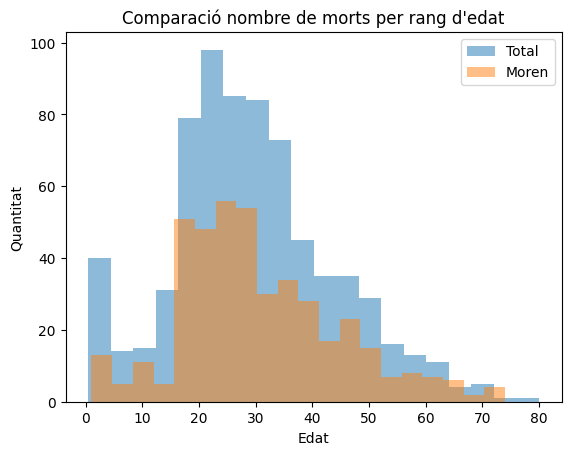

In [5]:
df_tot = data
df_died = data.loc[data['Survived'] == 0]
plt.hist(df_tot['Age'], bins=20, alpha=0.5, label='Total')
plt.hist(df_died['Age'], bins=20, alpha=0.5, label='Moren')
plt.xlabel("Edat")
plt.ylabel("Quantitat")
plt.title("Comparació nombre de morts per rang d'edat")
plt.legend()
plt.show()

A l'anterior grafic, podem obervar la quantitat de persones que tenen una edat determinada. A més, també observam damunt cada zona de l'histograma la quantitat de morts que hi hagueren en aquella franja d'edat. Podem veure que la franja d'edat més freqüentada és la de entre 20 i 30 anys. Tot hi que hi ha alguna excepció (com per exemple els nens de entre 0-5 anys), a la majoria de rangs d'edats hi trobem una quantitat de morts bastant proporcional a la quantitat total de persones en aquell rang.

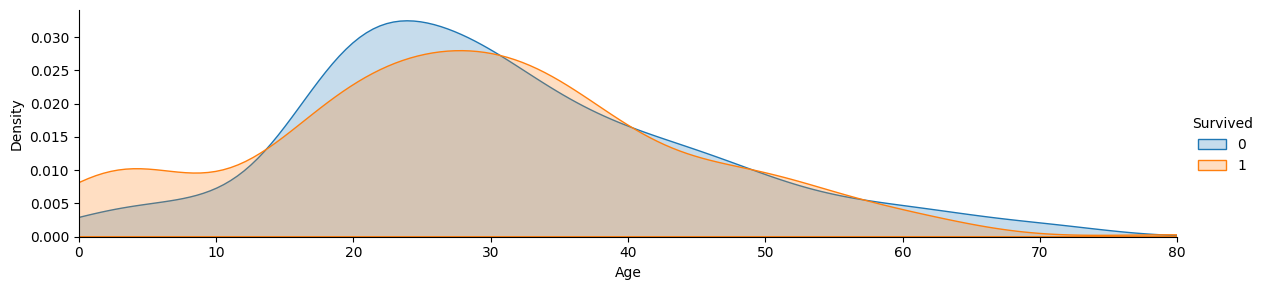

In [6]:
facet = sns.FacetGrid(data, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',fill= True)
facet.set(xlim=(0, data['Age'].max()))
facet.add_legend()

En aquest darrer gràfic, mostram la quantitat de persones que varen morir (a la llegenda 0) i sobreviure (a la llegenda 1) segons l'edat que tenen. Amb aquest grafic, confirmem el que ja preveiem observant l'histograma anterior: cada rang d'edats té una quantitat de morts bastant proporcional al total de persones en aquest. Podem remarcar que la franja d'edat dels "nens", tenen una quantitat de supervivents bastant més gran que de morts.

### 1.3 Sexe

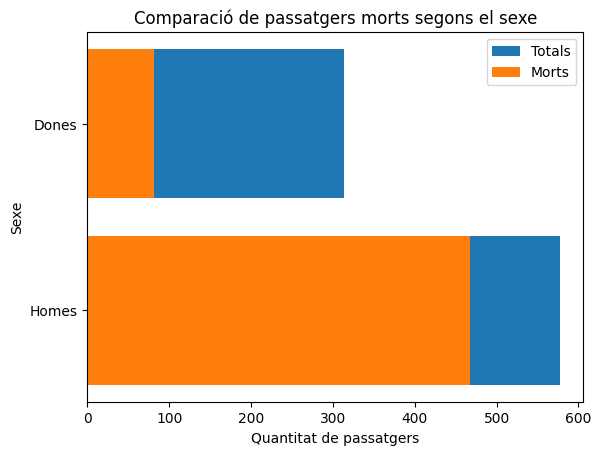

In [7]:
categories = ["Homes", "Dones"]
classes = [data.loc[(data.Sex == "male")].Sex.value_counts()['male'], data.loc[(data.Sex == "female")].Sex.value_counts()['female']]
moren = [data.loc[(data.Sex == "male") & (data.Survived == 0)].Sex.value_counts()['male'], data.loc[(data.Sex == "female") & (data.Survived == 0)].Sex.value_counts()['female']]
plt.barh(categories, classes)
plt.barh(categories, moren)
plt.xlabel("Quantitat de passatgers")
plt.ylabel("Sexe")
plt.title("Comparació de passatgers morts segons el sexe")
plt.legend(["Totals", "Morts"], loc="upper right", fontsize=10)
plt.show()

L'anterior grafic, evidencia el que era bastant previsible: el sexe de la persona és un atribut fundamental a l'hora de decidir si un passatger mor o sobreviu. Observam que la gran majoria d'homes varen morir, mentre que l gran majoria de dones varen sobreviure (degut a que als bots salvavides entraven primer els nens i dones).

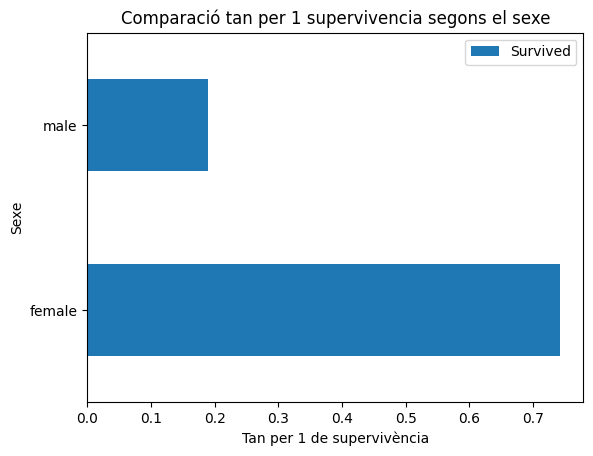

In [8]:
mitjaSupervivenciaSexe=pd.concat([data['Sex'], data['Survived']], axis=1).groupby('Sex').Survived.mean()
mitjaSupervivenciaSexe.plot(kind='barh')
plt.xlabel("Tan per 1 de supervivència")
plt.ylabel("Sexe")
plt.title("Comparació tan per 1 supervivencia segons el sexe")
plt.legend(loc="upper right")

Per acabar de confirmar les nostres sospites, hem realitzat aquest grafic on es mostren el tan per 1 d'homes i dones que es varen salvar. Com es es pot veure, la taxa de supervivència és de quasi el 80%, mentre que la dels homes no arriba al 20%.

### 1.4 Classe del Passatger

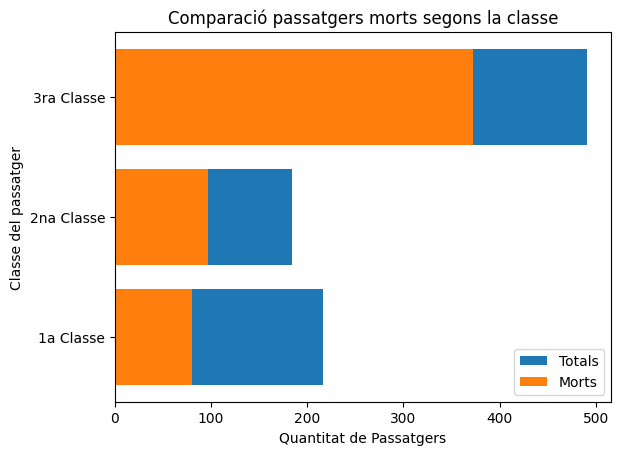

In [9]:
categories = ["1a Classe", "2na Classe", "3ra Classe"]
classes = [data.loc[(data.Pclass == 1)].Pclass.value_counts()[1], data.loc[(data.Pclass == 2)].Pclass.value_counts()[2], data.loc[(data.Pclass == 3)].Pclass.value_counts()[3]]
moren = [data.loc[(data.Survived == 0) & (data.Pclass == 1)].Pclass.value_counts()[1], data.loc[(data.Survived == 0) & (data.Pclass == 2)].Pclass.value_counts()[2], data.loc[(data.Survived == 0) & (data.Pclass == 3)].Pclass.value_counts()[3]]
plt.barh(categories, classes)
plt.barh(categories, moren)
plt.xlabel("Quantitat de Passatgers")
plt.ylabel("Classe del passatger")
plt.title("Comparació passatgers morts segons la classe")
plt.legend(["Totals", "Morts"], loc="lower right", fontsize=10)
plt.show()


En el gràfic anterior, podem veure la quantitat de persones de cada classe que viatjaven al titanic i, de cada una d'aquestes classes, veure quina quantitat de persones varen morir. Podem veure clarament que a primera classe, es varen salvar un percentatge de passatgers més alt que de segona i tercera classe. Aquest grafic ens fa adonar-nos que la classe del passatger és un factor important a l'hora de decidir si un passatger sobreviu o no.

### 1.5 Port d'Embarcació

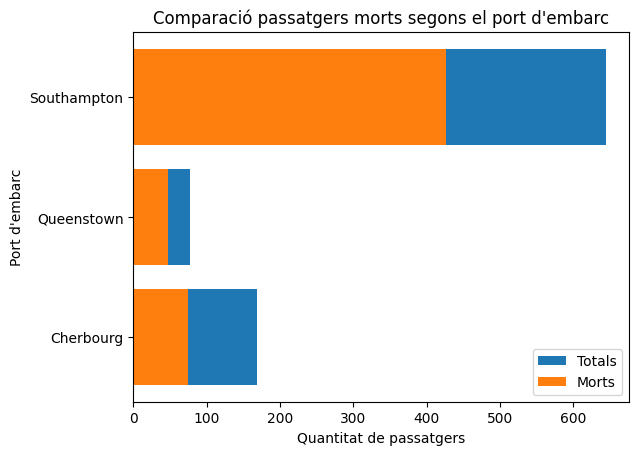

In [10]:
categories = ["Cherbourg", "Queenstown", "Southampton"]
classes = [data.loc[(data.Embarked == "C")].Embarked.value_counts()['C'], data.loc[(data.Embarked == "Q")].Embarked.value_counts()['Q'], data.loc[(data.Embarked == "S")].Embarked.value_counts()['S']]
moren = [data.loc[(data.Embarked == "C") & (data.Survived == 0)].Embarked.value_counts()['C'], data.loc[(data.Embarked == "Q") & (data.Survived == 0)].Embarked.value_counts()['Q'], data.loc[(data.Embarked == "S") & (data.Survived == 0)].Embarked.value_counts()['S']]
plt.barh(categories, classes)
plt.barh(categories, moren)
plt.xlabel("Quantitat de passatgers")
plt.ylabel("Port d'embarc")
plt.title("Comparació passatgers morts segons el port d'embarc")
plt.legend(["Totals", "Morts"], loc="lower right", fontsize=10)
plt.show()

A l'anterior grafic, podem obervar la quantita de passatger que varen embarcar a cada pot, a més de la quantitat de morts de passatgers que varen ambaracr en cada un d'ells. Observem que la gran majoria de passatgers varen embarcar a Southampton. En conceqüencia, més persones que varen embarcar en aquest port varen morir. Però en general, no veim una gran desproporció de morts respecte del total de cada classe. Per tant, amb aquest grafic no podem treure grans conclusions, però amb el següent si que podrem.

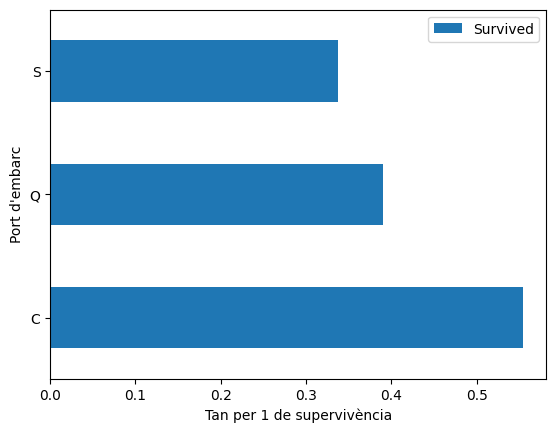

In [11]:
mitjaSupervivenciaEmbarked=pd.concat([data['Embarked'], data['Survived']], axis=1).groupby('Embarked').Survived.mean()
mitjaSupervivenciaEmbarked.plot(kind='barh')
plt.xlabel("Tan per 1 de supervivència")
plt.ylabel("Port d'embarc")
plt.legend(loc="upper right")

Com observam, la taxa de supervivència dels passatgers de Cherbourg és lleugerament més alta que la de la resta, i entre la de Queenston i Southampton no hi ha una gran diferència. Per tant, tot hi no ser un atribut crucial, s'haurà de tenir en compte per poder decidir si un passatger mor o sobreviu.

### 1.6 Familiars a bord

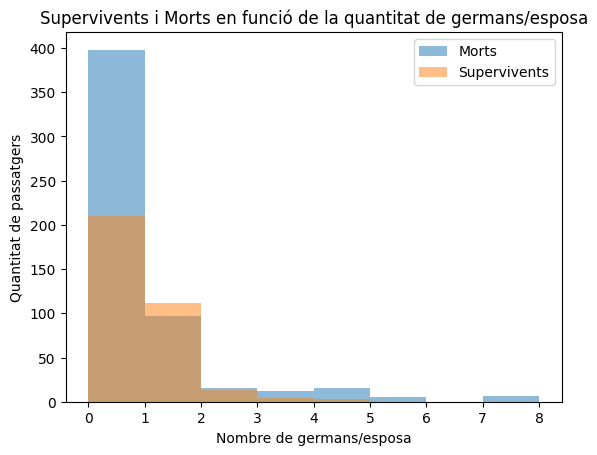

In [12]:
plt.hist(data[data["Survived"] == 0]["SibSp"], bins=range(0, data["SibSp"].max()+1), alpha=0.5, label="Morts")
plt.hist(data[data["Survived"] == 1]["SibSp"], bins=range(0, data["SibSp"].max()+1), alpha=0.5, label="Supervivents")
plt.xlabel("Nombre de germans/esposa")
plt.ylabel("Quantitat de passatgers")
plt.title("Supervivents i Morts en funció de la quantitat de germans/esposa")
plt.legend()
plt.show()

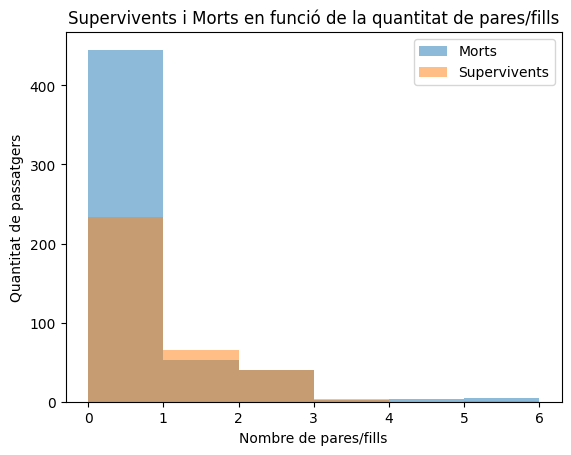

In [13]:
plt.hist(data[data["Survived"] == 0]["Parch"], bins=range(0, data["Parch"].max()+1), alpha=0.5, label="Morts")
plt.hist(data[data["Survived"] == 1]["Parch"], bins=range(0, data["Parch"].max()+1), alpha=0.5, label="Supervivents")
plt.xlabel("Nombre de pares/fills")
plt.ylabel("Quantitat de passatgers")
plt.title("Supervivents i Morts en funció de la quantitat de pares/fills")
plt.legend()
plt.show()

Els dos grafics anteriors ens mostren la quantitat de persones que varen morir/sobreviure a l'enfornsament, en funció de la quantitat de familiars que duien a bord. Per una part hem fet la comparació amb la quantitat de germans/esposa i per altre amb la quantitat de pares/fills. Les conclusions que en podem extreure d'quests grafics és que:

- Amb entre 0-1 familiars a bord (germans/esposa/pares/fills), la quantitat de morts és considerablament més gran que la de supervivents (més del doble).
- Amb 5 familiars (germans/esposa/pares/fills) o més, la quantitat de morts és molt superior a la seupervivents.
- Amb entre 1-4 pares/fills a bord, la quantitat de supervivents és molt parella a la quantitat de morts, o fins hi tot lleugerament major.
- Amb 2 germans/esposa o més, la quantitat de morts sempre és superior a la de supervivents.

Després d'extreure aquestes dades, podem dir que en líneas generals, els passatgers es salvaben més si tenien entre 1-3 familiars. Per tant, podem concloure que la quantitat de familiars, també és un factor a tenir en compte en la decisió de si un passatger sobreviu o mor.

### 1.7 Conclusions

Després d'haver explorat tot el nostre dataset del Titanic, obtenim aquestes conclusions:
1. La majoria de la gent té entre 20-30 anys.
2. La majoria són homes.
3. El % de supervivència en dones és molt major que els homes, suposant que tenien lloc abans en els bots auxiliars.
4. La majoria estava a tercera classe, suposam que era la més econòmica.
5. Molta més gent de primera classe es va salvar que gent de tercera o segona classe (proporcionalment a la qauntitat total de persones de la classe)
6. Atributs com el port d'embarcació, l'edat o la quantitat de familiars a bord, son factors a tenir en compte donat el seu impacte en la quantitat de morts o supervivents, però no son tan diferencials com el sexe o la classe del passatger.

## 2 Manipulació dades


EXPLICACIO GENERAL

### 2.1 Eliminació de Dades irrellevants

Després haver observat totes les dades i treure conclusions, anam a manipular les dades a un format correcte per al seu posterior ús en una fase d'entrenament. Primer de tot anem a veure quants de NaN valors tenim al nostre dataset.

<AxesSubplot:>

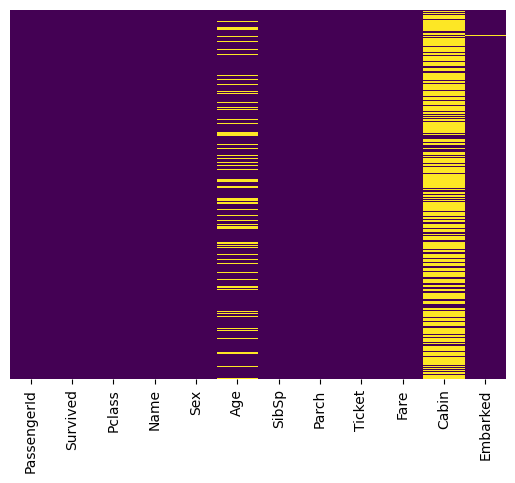

In [14]:
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [15]:
print("La quantitat de NAN's en Cabin es {}/{}".format(data['Cabin'].isna().sum(),len(data)))

La quantitat de NAN's en Cabin es 687/891


Després d'haver observat que la major part de valors de la columna "Cabin" son NAN's, arribem a la conclusió que el més adeqüat és eliminar la columna. També podem observar que tant PassengerID com ticket i Name ens serveixen de identificadors, informació que no serà rellevant a l'hora de determinar si un passatger sobreviurà o morirà. Per tant, també podem eliminar aquestes columnes.

In [16]:
#Eliminam les columnes "PassengerId","Ticket","Name","Cabin".
data.drop(["PassengerId","Ticket","Name","Cabin"],inplace=True,axis=1)

In [17]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### 2.2 Emplenar Caselles amb Valors NAN Restants

Ara, després d'haver eliminat les característiques que trobam innecessàries o millor dit, no rellevants, observarem si ens falta informació a la resta de columnes.

In [18]:
total = data.isnull().sum().sort_values(ascending = False)
percentatge = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
ms=pd.concat([total, percentatge], axis=1, keys=['Total', 'percentatge'])
ms= ms[ms["percentatge"] > 0]
ms

,Total,percentatge
Age,177,19.865320
Embarked,2,0.224467


Com podem observar, ens falten 177 valors per a l'edat i 2 per a Embarked. Ens centrarem principalment en l'edat ja que és una característica molt més important i que té més relació amb la supervivència. L'opció més viable és substituir tots aquests valors per la mitjana. A més, eliminarem les dues files amb el valor NaN de Embarked.

In [19]:
# Emplenam els 177 valors NAN de la columna "Age" amb la mitjana
data['Age'].fillna(value=data['Age'].median(),inplace=True)

In [20]:
# Eliminam les 2 files que tenen el valor de "Embarked" a NAN
data.dropna(subset=['Embarked'],inplace=True)

### 2.3 Dades Categòriques

En aquesta fase de la neteja de dades obtindrem les dades categòriques i les transformarem a numèriques per a poder entrenar amb elles el nostre model. 

In [21]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Tenim dues columnes categòriques, el "sexe" i "Embarked". Utilitzarem una substitució per 1 en el cas de home i 0 en el cas de dona ja que tan sols hi ha dos possibles valors. En el cas de Embarked i , utilitzarem el one hot encoding (hi ha 3 possibles valors), on es crearan 3 noves columnes que representaran els 3 ports possibles d'embarcament al vaixell (S, C, Q). En aquestes columnes, s'indicarà si un determinat passatger va embarcar (1) o no (0) en aquest determinat port. 

In [22]:
data['Sex']=data['Sex'].map({'male':1,'female':0}) #Canviam els valors de sexe
embark=data.pop('Embarked')
ohe_embark=pd.get_dummies(embark,prefix='embk')
data=pd.concat([data.reset_index(drop=True),ohe_embark.reset_index(drop=True)],axis=1,sort=False)


Tot i no ser una dada categòrica, plantejarem la mateixa estratègia per a la classe del passatger. Utilitzarem el one hot encoding per crear 3 noves columnes que substituiran a "Pclass". Dintre de cada una d'aquestes indicarem amb un valor booleà si aquest determinat passatger pertany (1) o no (0) a aquesta classe determinada.

In [23]:
pclass=data.pop('Pclass')
ohe_class=pd.get_dummies(pclass,prefix='class')
data=pd.concat([data.reset_index(drop=True),ohe_class.reset_index(drop=True)],axis=1,sort=False)


In [24]:
data.head()

,Survived,Sex,Age,SibSp,Parch,Fare,embk_C,embk_Q,embk_S,class_1,class_2,class_3
0,0,1,22.0,1,0,7.2500,0,0,1,0,0,1
1,1,0,38.0,1,0,71.2833,1,0,0,1,0,0
2,1,0,26.0,0,0,7.9250,0,0,1,0,0,1
3,1,0,35.0,1,0,53.1000,0,0,1,1,0,0
4,0,1,35.0,0,0,8.0500,0,0,1,0,0,1


### 2.3 Normalització de Dades

Com a darrera passa per a tenir les dades netes, hauríem de normalitzar les columnes amb valors numèrics alts com Age o Fare. Utilitzarem l'StandardScaler de la llibreria sklearn.

In [25]:
# Normalització de Dades
scaler = StandardScaler()
data.Age=scaler.fit_transform(data.Age.values.reshape(-1,1))
data.Fare=scaler.fit_transform(data.Fare.values.reshape(-1,1))
data.SibSp=scaler.fit_transform(data.SibSp.values.reshape(-1,1))
data.Parch=scaler.fit_transform(data.Parch.values.reshape(-1,1))
data.head()

,Survived,Sex,Age,SibSp,Parch,Fare,embk_C,embk_Q,embk_S,class_1,class_2,class_3
0,0,1,-0.563674,0.431350,-0.474326,-0.500240,0,0,1,0,0,1
1,1,0,0.669217,0.431350,-0.474326,0.788947,1,0,0,1,0,0
2,1,0,-0.255451,-0.475199,-0.474326,-0.486650,0,0,1,0,0,1
3,1,0,0.438050,0.431350,-0.474326,0.422861,0,0,1,1,0,0
4,0,1,0.438050,-0.475199,-0.474326,-0.484133,0,0,1,0,0,1


In [26]:
label=data['Survived']

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.35, random_state=42)
X_train.pop('Survived')
X_test.pop('Survived')

280    0
434    1
39     1
417    0
584    1
      ..
819    1
323    0
185    1
41     0
545    1
Name: Survived, Length: 312, dtype: int64

In [27]:
data.corr()

,Survived,Sex,Age,SibSp,Parch,Fare,embk_C,embk_Q,embk_S,class_1,class_2,class_3
Survived,1.000000,-0.541585,-0.069822,-0.034040,0.083151,0.255290,0.169966,0.004536,-0.151777,0.282368,0.095002,-0.320171
Sex,-0.541585,1.000000,0.086506,-0.116348,-0.247508,-0.179958,-0.084520,-0.075217,0.121405,-0.093142,-0.066459,0.134227
Age,-0.069822,0.086506,1.000000,-0.232543,-0.171485,0.093707,0.032098,-0.030436,-0.008964,0.319924,0.017724,-0.289498
SibSp,-0.034040,-0.116348,-0.232543,1.000000,0.414542,0.160887,-0.060074,-0.026692,0.069438,-0.052894,-0.056507,0.091515
Parch,0.083151,-0.247508,-0.171485,0.414542,1.000000,0.217532,-0.011588,-0.081585,0.061512,-0.015809,-0.001278,0.014634
Fare,0.255290,-0.179958,0.093707,0.160887,0.217532,1.000000,0.270731,-0.116684,-0.163758,0.590576,-0.117609,-0.411932
embk_C,0.169966,-0.084520,0.032098,-0.060074,-0.011588,0.270731,1.000000,-0.148646,-0.782613,0.299472,-0.126039,-0.154785
embk_Q,0.004536,-0.075217,-0.030436,-0.026692,-0.081585,-0.116684,-0.148646,1.000000,-0.499261,-0.154680,-0.127705,0.237035
embk_S,-0.151777,0.121405,-0.008964,0.069438,0.061512,-0.163758,-0.782613,-0.499261,1.000000,-0.165022,0.190824,-0.013594
class_1,0.282368,-0.093142,0.319924,-0.052894,-0.015809,0.590576,0.299472,-0.154680,-0.165022,1.000000,-0.287653,-0.625395


Després d'haver fet la neteja de dades i obtingut la matriu de correlació ens adonem compte que els principals factors que intervenen en la predicció i que tenen més importància són aquests:

1. class_1, class_2 i class_3: amb uns valors de 0.282368, 0.0.095002 i -0.320171 respectivament, podem observar que quant major és el nombre de classe, menys probabilitats de sobreviure.
2. Sex: amb un valor de -0.54, significa que quan major sigui aquest valor menor probabilitat de supervivència tindrà la persona. Això es dona ja que hem substituit home per 1 i dona per 0. Si fos al revés, és a dir, que dona fos un nombre inferior que home, aquesta correlació siria positiva, al tenir més probabilitats de sobreviure quan major sigui el nombre enter.
3. Fare: té un valor de 0.25, indica la quantitat de diners que es varen pagar. Aquesta columna va lligada amb Pclass ja que quant més es pagava, millor classe es tenia i per tant, major % de sobreviure.
4. embk_C, embk_Q i embk_S: amb uns valors de 0.169966, 0.004536 i -0.151777 respectivament, podem observar que si el passatger es va embarcar al vaixell a Cherbourg té més possibilitats de sobreviure que si es va embarcar a Queenstown o Southampton (encara que a priori no pareixi que hagi d'influir, si que ho fa)

## 3 Models de Classificació


### 3.1 Regressió Logística


#### 3.1.1 Entrenament

En aquesta fase, entrenarem el model i mostrarem una funció que va mostrant 

In [28]:
logistic_reg=linear_model.LogisticRegression()
hist=logistic_reg.fit(X_train,y_train)

# Initialize an empty list to store the losses
losses = []

# For each epoch of training
for i in range(logistic_reg.n_iter_[0]):
    # Get the predicted probabilities for each example in the training set
    y_proba = logistic_reg.predict_proba(X_train)
    
    # Calculate the cross-entropy loss
    loss = log_loss(y_train, y_proba)
    
    # Append the loss to the losses list
    losses.append(loss)

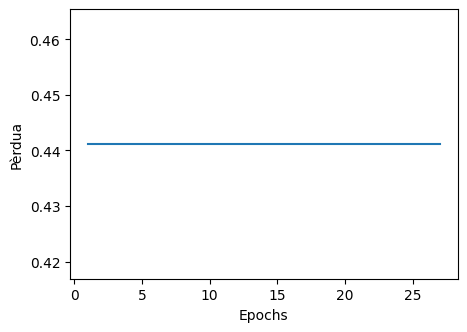

In [29]:
# Plot the loss as a function of the epoch number
f = plt.figure()
f.set_figwidth(5)
f.set_figheight(3.5)
plt.plot(range(1, len(losses)+1), losses)
plt.xlabel('Epochs')
plt.ylabel('Pèrdua')
plt.show()

Aquest gràfic encara que pareixi que no ens serveix, ens demostra que el model amb 1 epoch, és a dir, un recorregut sencer sobre el dataset, ja ha aconseguit el mínim loss. Si treballessim amb datasets més grans,veuríem com aquesta pèrdua aniria disminuint, això passa sobretot en grans xarxes neuronals que tenen molts més paràmetres que la nostra regressió logística.

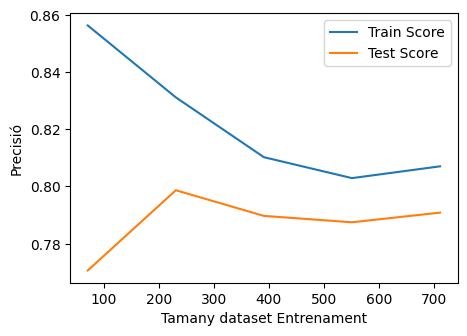

In [30]:
#Obtenim la columna que volem prediure dins una variable.
i = data
y=i.pop('Survived')
#Obtenim tamany de datasets, precisions d'entrenament i test per a visualitzar
train_size_abs, train_scores, test_scores= learning_curve(
     logistic_reg, data, y
 )


# Gràfic per a veure com evoluciona la precisió segons el tamany del dataset
f = plt.figure()
f.set_figwidth(5)
f.set_figheight(3.5)
plt.plot(train_size_abs,np.mean(train_scores,axis=1),label='Train Score')
plt.plot(train_size_abs,np.mean(test_scores,axis=1),label='Test Score')
plt.xlabel('Tamany dataset Entrenament')
plt.ylabel("Precisió")
plt.legend()
plt.show()

Com podem veure adalt, ens trobam aquest gràfic per a veure com canvia la precisió segons el tamany del dataset.El punt òptim és on el test score és màxim i train és un valor superior. Ens referiem a un nombre entre 250-300, és a dir un 30% aproximadament del test size.Ens podem trobar amb dues situacions possibles:

1. Overfitting: si tenim poques dades i entrenam el model molts de cops amb aquestes, només es memoritzarà aquestes solucions. Es pot resoldre augmentant el nombre de dades o no realitzant tantes iteracions sobre el dataset.
2. Underfitting: si no tenim suficients dades, al model li queda molt per aprendre i no té una precisió adequada. Es pot apreciar en el rang de 100-200, on la precisió del test va augmentant, és a dir, està aprenent.


#### 3.1.2 Avaluació

Per avaluar la correctesa del nostre model utilitzarem aquestes mètriques:

1. Precisió(Accuracy): es refereix al percentatge d'acerts entre total.
2. Pèrdua(Logistic Loss): es refereix a la funció de quan enfora arriba a ser l'error de predicció del model.
3. Puntuació F1(F1 Score): es refereix a la mitja harmònica de la precisió i el 'Rceall'. La diferència és que aquesta mètrica castiga més els valors extrems.

In [31]:
prediccio=logistic_reg.predict(X_test)
precisio=round(accuracy_score(prediccio,y_test)*100,2)
perdua=log_loss(y_test,prediccio)
f1=f1_score(y_test,prediccio)
print(classification_report(y_test, prediccio))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       190
           1       0.78      0.75      0.76       122

    accuracy                           0.82       312
   macro avg       0.81      0.80      0.81       312
weighted avg       0.82      0.82      0.82       312



In [32]:
print('La precisió del nostre model és: ',round(accuracy_score(prediccio,y_test)*100,2))
print('La pèrdua del nostre model és: ',perdua )
print('La puntuació F1 del nostre model és: ',round(f1*100,2))

La precisió del nostre model és:  81.73
La pèrdua del nostre model és:  6.31003539757402
La puntuació F1 del nostre model és:  76.15


#### 3.1.3 Parameter tuning

Parameter tuning es la fase on es tracta d'optimitzar la millor combinació possible de paràmetres per a millorar la precisió del model. En el nostre cas, hem escollit aquests paràmetres:

1. Penalty: 
2. Tolerance:
3. C:
4. Solver: escollir l'algoritme d'optimització. Per defecte s'utilitza 'lbfgs'.Li donarem tots els valors possibles: ‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’.

In [33]:
penal=['l1', 'l2', 'elasticnet', None]
tole=np.arange(1e-4,0.01,0.0005)
Ce=np.logspace(-3,3,7)
solv=['lbfgs','liblinear','newton-cg','newton-cholesky','sag','saga']
parameters={'penalty':penal,'tol':tole,'C':Ce,'solver':solv}
grid=GridSearchCV(estimator=logistic_reg,param_grid=parameters,cv = 2, n_jobs=-1)

In [34]:
grid.fit(X_train, y_train);
grid.best_params_


C:\Users\Jaume\miniconda3\envs\ia2022\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
4760 fits failed out of a total of 6720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
280 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Jaume\miniconda3\envs\ia2022\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jaume\miniconda3\envs\ia2022\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Jaume\miniconda3\envs\ia2022\lib\site-packages\sklearn\linear_model\_logistic.p

{'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.0001}

Els millors paràmetres són els següents:

1. C: 1.0
3. Penalty: 'l2'
3. Solver: 'sag'
4. Tol: '0.0081'

#### 3.1.4 Avaluació amb paràmetres òptims

Després d'haver utilitzat la tècnica del parameter tuning i haver provat el model amb tantes combinacions diferentes com desitjat, l'avaluarem de nou i compararem la millora.

In [60]:

logistic_reg=linear_model.LogisticRegression(C=1.0,penalty= 'l2',solver='sag',tol=0.0081)
hist=logistic_reg.fit(X_train,y_train)


prediccio=logistic_reg.predict(X_test)
precisio2=round(accuracy_score(prediccio,y_test)*100,2)
perdua2=log_loss(y_test,prediccio)
f12=f1_score(y_test,prediccio)
print(classification_report(y_test, prediccio))

print('La precisió del nostre model és: ',precisio2)
print('La pèrdua del nostre model és: ',perdua2 )
print('La puntuació F1 del nostre model és: ',round(f12*100,2))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85       190
           1       0.78      0.75      0.76       122

    accuracy                           0.82       312
   macro avg       0.81      0.81      0.81       312
weighted avg       0.82      0.82      0.82       312

La precisió del nostre model és:  82.05
La pèrdua del nostre model és:  6.1993316283677995
La puntuació F1 del nostre model és:  76.47


#### 3.1.5 Comparació inicial vs optimitzat

In [69]:
Precisio=[precisio,precisio2]
perdues=[perdua,perdua2]
precisionsF1=[f1,f12]
matriu=zip(Precisio,perdues,precisionsF1)
taula_Comparacio=pd.DataFrame(matriu,columns=['Precisió','Pèrdua','F1 Score'])
taula_Comparacio

,Precisió,Pèrdua,F1 Score
0,81.73,6.199332,0.764706
1,82.05,6.199332,0.764706


### 3.2 Perceptró

#### 3.2.1 Entrenament

El primer que hem de fer és dividir les dades que hem modificat entre train i test. Ho fem amb la llibreria sk-learn.

In [37]:
label=data['Survived']
# Separem les dades en train i test
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.35, random_state=42)
X_train.pop('Survived');
X_test.pop('Survived');

KeyError: 'Survived'

Una vegada dividides les dades, passarem aa entrenar el classificador perceptró amb les dades de train.

In [ ]:
# Entrenem el classificador
percep = linear_model.Perceptron(tol=1e-3, random_state=42)
percep.fit(X_train, y_train);

#### 3.2.1 Avaluació

In [ ]:
pred = percep.predict(X_test)

In [ ]:
print('The accuracy of the Logistic Regression is',round(accuracy_score(pred,y_test)*100,2))

In [ ]:
print(classification_report(y_test, pred))

#### 3.2.3 Parameter tuning

## 1.4 Avaluació


In [ ]:
prediccio=logistic_reg.predict(X_test)
print('The accuracy of the Logistic Regression is',round(accuracy_score(prediccio,y_test)*100,2))

## 1.5 Funció avaluació segons test size


In [ ]:
x=np.arange(0.05, 0.80, 0.01, dtype=float)
y=[]
for i in x:
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=i, random_state=42)
    logistic_reg=linear_model.LogisticRegression()
    hist=logistic_reg.fit(X_train,y_train)
    prediccio=logistic_reg.predict(X_test)
    y.append(round(accuracy_score(prediccio,y_test)*100,2))

In [ ]:
y
plt.plot(x,y)
plt.show
plt.legend("percentatge de precisió segons la distribució train-test",loc="upper right")

In [ ]:
percep=linear_model.Perceptron()
percep.fit(X_train,y_train)
importance=percep.coef_
print(importance)
# plot feature importance

In [ ]:
predict=percep.predict(X_test)


In [ ]:
x=np.arange(0.05, 0.80, 0.01, dtype=float)
y=[]
for i in x:
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=i, random_state=42)
    X_train.pop('Survived')
    X_test.pop('Survived')
    percep=linear_model.Perceptron(tol=1e-3,random_state=0)
    percep.fit(X_train,y_train)
    prediccio=logistic_reg.predict(X_test)
    y.append(round(accuracy_score(prediccio,y_test)*100,2))

In [ ]:
y
plt.plot(x,y)
plt.show
plt.legend("hola",loc="upper right")

In [ ]:
print("Accuracy: "+str(accuracy_score(predict,y_test)))

In [ ]:
from sklearn import tree

In [ ]:
decision_tree = tree.DecisionTreeClassifier(max_depth = 4)
decision_tree.fit(X_train, y_train)
predict=decision_tree.predict(X_test)
print("Accuracy: "+str(accuracy_score(predict,y_test)))